Train size: 24005
Validation size: 2401
Test size: 211
Number of disease classes: 2392
disease
fibroids/treatment                                  20
contraception/the pill progestogen only             20
first aid                                           20
baby/weaning and feeding/babys first solid foods    20
contraception/change different pill                 20
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_31912\1583403619.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


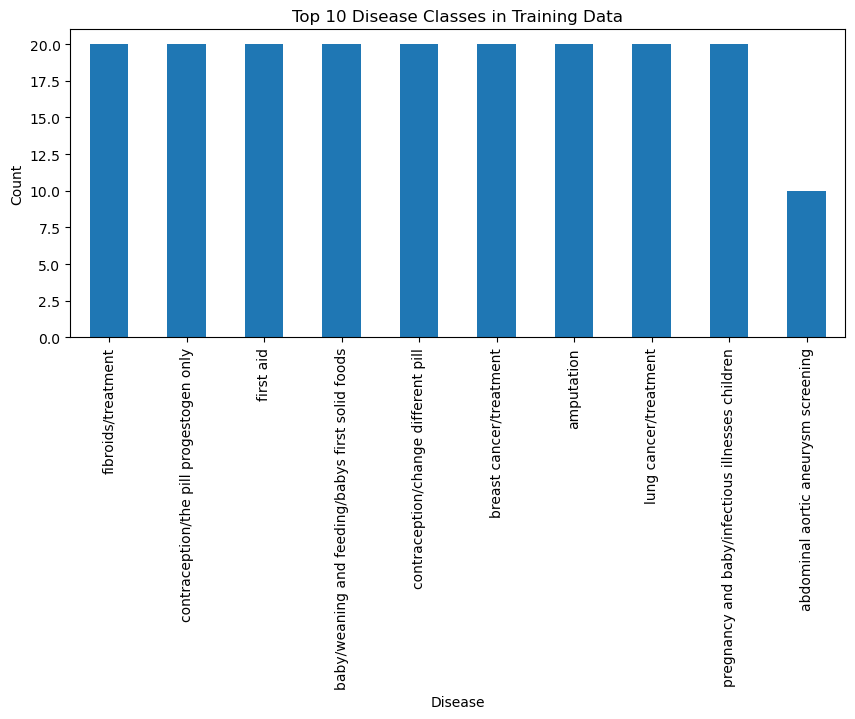

In [12]:
import matplotlib.pyplot as plt

# Descriptive stats
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
print("Number of disease classes:", train_df['disease'].nunique())
print(train_df['disease'].value_counts().head())

# Plot class distribution
train_df['disease'].value_counts().head(10).plot(kind='bar', figsize=(10,4))
plt.title("Top 10 Disease Classes in Training Data")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [1]:
#Run 1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from rouge_score import rouge_scorer

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Load Data
train_df = pd.read_csv('patient_qa_train.csv')
test_df = pd.read_csv('patient_qa_test.csv')

# Preprocess
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Tokenize, lowercase, lemmatize each word
    tokens = word_tokenize(str(text).lower(), language='english')
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

train_df['question_preprocessed'] = train_df['question'].apply(preprocess_text)
test_df['question_preprocessed'] = test_df['question'].apply(preprocess_text)

# Split train/val
train_df_main, val_df = train_test_split(
    train_df, test_size=0.1, stratify=train_df['disease'], random_state=42
)

# Model 1 - TF-IDF Retrieval 
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english') #Optimised Hyperparameters
tfidf_train = vectorizer.fit_transform(train_df_main['question_preprocessed'])
tfidf_val = vectorizer.transform(val_df['question_preprocessed'])
tfidf_test = vectorizer.transform(test_df['question_preprocessed'])

# generate cosine similarities and pick best match
def retrieve_answer(tfidf_q, tfidf_corpus, corpus_answers):
    sims = cosine_similarity(tfidf_q, tfidf_corpus)
    idx = sims.argmax(axis=1)
    return [corpus_answers.iloc[i] for i in idx]

val_preds_tfidf = retrieve_answer(tfidf_val, tfidf_train, train_df_main['answer'])
test_preds_tfidf = retrieve_answer(tfidf_test, tfidf_train, train_df_main['answer'])

# Calculate average ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
def get_avg_rouge(preds, refs):
    scores = {'rouge1':[], 'rouge2':[], 'rougeL':[]}
    for p, r in zip(preds, refs):
        s = scorer.score(r, p)
        for k in scores:
            scores[k].append(s[k].fmeasure)
    return {k: round(sum(v)/len(v), 4) for k,v in scores.items()}

scores_val_tfidf = get_avg_rouge(val_preds_tfidf, val_df['answer'])
scores_test_tfidf = get_avg_rouge(test_preds_tfidf, test_df['answer'])
print("Validation ROUGE (TF-IDF):", scores_val_tfidf)
print("Test ROUGE (TF-IDF):", scores_test_tfidf)

# Model 2 - T5 
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

train_dataset = Dataset.from_pandas(train_df_main[['question', 'answer']])
val_dataset = Dataset.from_pandas(val_df[['question', 'answer']])
test_dataset = Dataset.from_pandas(test_df[['question', 'answer']])

# Tokenizing questions and answers
train_dataset = train_dataset.map(lambda e: tokenizer(e['question'], truncation=True, padding='max_length', max_length=64), batched=True)
train_dataset = train_dataset.map(lambda e: {'labels': tokenizer(e['answer'], truncation=True, padding='max_length', max_length=64)['input_ids']}, batched=True)

#training arguments 
training_args = TrainingArguments(
    output_dir='./results', 
    num_train_epochs=3, #Optimised Hyperparameters
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5, #Optimised Hyperparameters
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

# Test set predictions
inputs = tokenizer(test_df['question'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=64)
outputs = model.generate(inputs['input_ids'], max_length=64)
test_preds_t5 = tokenizer.batch_decode(outputs, skip_special_tokens=True)
scores_test_t5 = get_avg_rouge(test_preds_t5, test_df['answer'])
print("Test ROUGE (T5):", scores_test_t5)

# Validation set predictions
val_inputs = tokenizer(val_df['question'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=64)
val_outputs = model.generate(val_inputs['input_ids'], max_length=64)
val_preds_t5 = tokenizer.batch_decode(val_outputs, skip_special_tokens=True)
scores_val_t5 = get_avg_rouge(val_preds_t5, val_df['answer'])
print("Validation ROUGE (T5):", scores_val_t5)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Validation ROUGE (TF-IDF): {'rouge1': 0.2799, 'rouge2': 0.0929, 'rougeL': 0.2022}
Test ROUGE (TF-IDF): {'rouge1': 0.8393, 'rouge2': 0.8016, 'rougeL': 0.8258}


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/21604 [00:00<?, ? examples/s]

Map:   0%|          | 0/21604 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,2.875500
1000,2.377600
1500,2.288100
2000,2.278600
2500,2.233300
3000,2.229600
3500,2.176300
4000,2.216200
4500,2.176500
5000,2.206300


Test ROUGE (T5): {'rouge1': 0.2767, 'rouge2': 0.1182, 'rougeL': 0.2279}
Validation ROUGE (T5): {'rouge1': 0.3099, 'rouge2': 0.1419, 'rougeL': 0.2563}


In [2]:
#Run 2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from rouge_score import rouge_scorer

nltk.download('punkt')
nltk.download('wordnet')

# Load Data
train_df = pd.read_csv('patient_qa_train.csv')
test_df = pd.read_csv('patient_qa_test.csv')

# Preprocess
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = word_tokenize(str(text).lower(), language='english')
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

train_df['question_preprocessed'] = train_df['question'].apply(preprocess_text)
test_df['question_preprocessed'] = test_df['question'].apply(preprocess_text)

# Split train/val
train_df_main, val_df = train_test_split(
    train_df, test_size=0.1, stratify=train_df['disease'], random_state=42
)

# Model 1 - TF-IDF Retrieval with different values 
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words='english') #Optimised Hyperparameters
tfidf_train = vectorizer.fit_transform(train_df_main['question_preprocessed'])
tfidf_val = vectorizer.transform(val_df['question_preprocessed'])
tfidf_test = vectorizer.transform(test_df['question_preprocessed'])

def retrieve_answer(tfidf_q, tfidf_corpus, corpus_answers):
    sims = cosine_similarity(tfidf_q, tfidf_corpus)
    idx = sims.argmax(axis=1)
    return [corpus_answers.iloc[i] for i in idx]

val_preds_tfidf = retrieve_answer(tfidf_val, tfidf_train, train_df_main['answer'])
test_preds_tfidf = retrieve_answer(tfidf_test, tfidf_train, train_df_main['answer'])

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
def get_avg_rouge(preds, refs):
    scores = {'rouge1':[], 'rouge2':[], 'rougeL':[]}
    for p, r in zip(preds, refs):
        s = scorer.score(r, p)
        for k in scores:
            scores[k].append(s[k].fmeasure)
    return {k: round(sum(v)/len(v), 4) for k,v in scores.items()}

scores_val_tfidf = get_avg_rouge(val_preds_tfidf, val_df['answer'])
scores_test_tfidf = get_avg_rouge(test_preds_tfidf, test_df['answer'])
print("Validation ROUGE (TF-IDF):", scores_val_tfidf)
print("Test ROUGE (TF-IDF):", scores_test_tfidf)

# Model 2 - T5 with different values
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

train_dataset = Dataset.from_pandas(train_df_main[['question', 'answer']])
val_dataset = Dataset.from_pandas(val_df[['question', 'answer']])
test_dataset = Dataset.from_pandas(test_df[['question', 'answer']])

train_dataset = train_dataset.map(lambda e: tokenizer(e['question'], truncation=True, padding='max_length', max_length=64), batched=True)
train_dataset = train_dataset.map(lambda e: {'labels': tokenizer(e['answer'], truncation=True, padding='max_length', max_length=64)['input_ids']}, batched=True)

training_args = TrainingArguments(
    output_dir='./results', 
    num_train_epochs=5,  #Optimised Hyperparameters
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,  #Optimised Hyperparameters
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

# Test set predictions
inputs = tokenizer(test_df['question'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=64)
outputs = model.generate(inputs['input_ids'], max_length=64)
test_preds_t5 = tokenizer.batch_decode(outputs, skip_special_tokens=True)
scores_test_t5 = get_avg_rouge(test_preds_t5, test_df['answer'])
print("Test ROUGE (T5):", scores_test_t5)

# Validation set predictions
val_inputs = tokenizer(val_df['question'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=64)
val_outputs = model.generate(val_inputs['input_ids'], max_length=64)
val_preds_t5 = tokenizer.batch_decode(val_outputs, skip_special_tokens=True)
scores_val_t5 = get_avg_rouge(val_preds_t5, val_df['answer'])
print("Validation ROUGE (T5):", scores_val_t5)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Validation ROUGE (TF-IDF): {'rouge1': 0.284, 'rouge2': 0.0972, 'rougeL': 0.2063}
Test ROUGE (TF-IDF): {'rouge1': 0.8757, 'rouge2': 0.8471, 'rougeL': 0.8657}


Map:   0%|          | 0/21604 [00:00<?, ? examples/s]

Map:   0%|          | 0/21604 [00:00<?, ? examples/s]

Step,Training Loss
500,2.658000
1000,2.322300
1500,2.237100
2000,2.226700
2500,2.179500
3000,2.169900
3500,2.113800
4000,2.149200
4500,2.108200
5000,2.133100


Test ROUGE (T5): {'rouge1': 0.284, 'rouge2': 0.1203, 'rougeL': 0.2332}
Validation ROUGE (T5): {'rouge1': 0.3185, 'rouge2': 0.1501, 'rougeL': 0.2652}


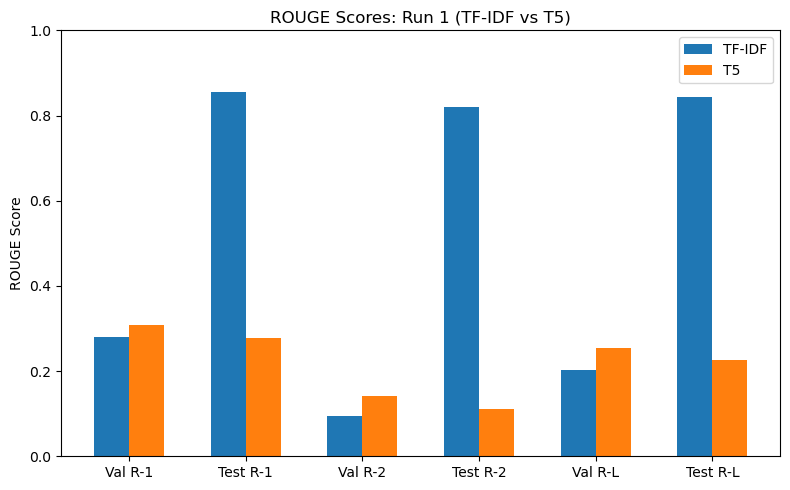

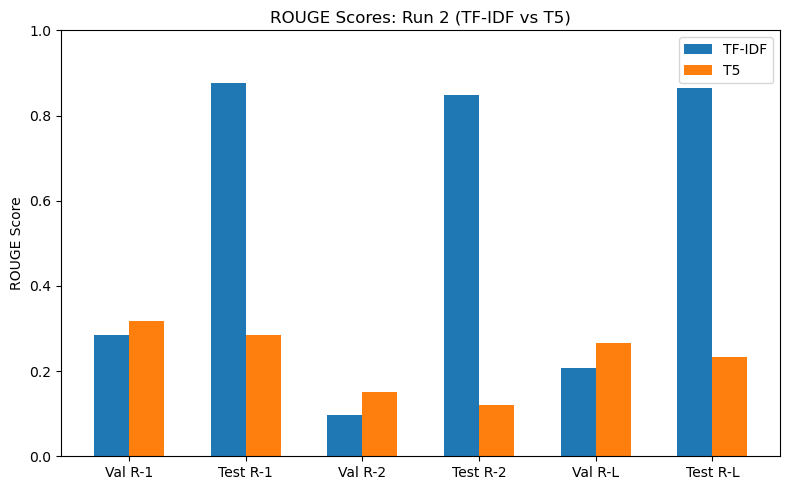

In [13]:
# Run 1: TF-IDF vs T5
tfidf_run1 = [0.2811, 0.8546, 0.0943, 0.8206, 0.2031, 0.8426]
t5_run1 = [0.3077, 0.2771, 0.1423, 0.1118, 0.2547, 0.2257]
labels = ['Val R-1', 'Test R-1', 'Val R-2', 'Test R-2', 'Val R-L', 'Test R-L']

plt.figure(figsize=(8,5))
plt.bar(np.arange(6)-0.15, tfidf_run1, width=0.3, label='TF-IDF')
plt.bar(np.arange(6)+0.15, t5_run1, width=0.3, label='T5')
plt.xticks(np.arange(6), labels)
plt.ylim(0,1)
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores: Run 1 (TF-IDF vs T5)')
plt.legend()
plt.tight_layout()
plt.show()

# Run 2: TF-IDF vs T5
tfidf_run2 = [0.2840, 0.8757, 0.0972, 0.8471, 0.2063, 0.8657]
t5_run2 = [0.3185, 0.2840, 0.1501, 0.1203, 0.2652, 0.2332]

plt.figure(figsize=(8,5))
plt.bar(np.arange(6)-0.15, tfidf_run2, width=0.3, label='TF-IDF')
plt.bar(np.arange(6)+0.15, t5_run2, width=0.3, label='T5')
plt.xticks(np.arange(6), labels)
plt.ylim(0,1)
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores: Run 2 (TF-IDF vs T5)')
plt.legend()
plt.tight_layout()
plt.show()
